NYU Center for Data Science

DS-GA 1003 Machine Learning

HW5 - SGD for Multiclass Linear SVM

Stephen Spivack (ss7726@nyu.edu)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn import metrics
from sklearn import svm
%matplotlib inline

### 1) Bayesian Modeling

#### Bayesian Logistic Regression with Gaussian Priors

This question analyzes logistic regression in the Bayesian setting, where we introduce a prior $p(w)$ on $w \in \mathbb{R}^d$. Consider a binary classification setting with input space $X = \mathbb{R}^d$, outcome space $y_{\pm} = \{-1,1\}$, and a dataset $D = ((x^1, y^1), ..., (n^n, y^n))$.

1) Give an expression for the posterior density $p(w | D)$ in terms of the negative log-likelihood
function $NLL_D(w)$ and the prior density $p(w)$ (up to a proportionality constant is fine).

$NLL_D(w) = -\sum_{i=1}^n y'_i log(f(w^T x_i)) + (1-y'_i) log(1-f(w^T x_i))$

$p(w|D) = \frac{p(D|w)p(w)}{p(D)} = \frac{e^{-NLL_D(w)}p(w)}{p(D)}$

2) Suppose we take a prior on $w$ of the form $w ∼ N (0, \Sigma)$, that is in the Gaussian family. Is
this a conjugate prior to the likelihood given by logistic regression?

No, a Gaussian prior on $w$ is not a conjugate prior to the likelihood given by logistic regression. In logistic regression, the likelihood function is a product of sigmoid functions.  Therefore, the posterior distribution will not be Gaussian even if we use a Gaussian prior on $w$.

3) Show that there exist a covariance matrix $\Sigma$ such that MAP (maximum a posteriori) estimate for $w$ after observing data $D$ is the same as the minimizer of the regularized logistic regression function defined in Regularized Logistic Regression paragraph above, and give its value.

$p(w|D) \propto p(D|w)p(w)$

$-log(p(w|D)) \propto -\sum_{i=1}^n [y_i' log(f(w^T x_i)) + (1-y_i') log(1 - f(w^T x_i))] - log(p(w))$

$log(p(w)) \propto -\frac{1}{2} w^T \Sigma^{-1} w$

$\Sigma = \frac{1}{2n\lambda}$

4) In the Bayesian approach, the prior should reflect your beliefs about the parameters before seeing the data and, in particular, should be independent on the eventual size of your dataset. Imagine choosing a prior distribution $w ∼ N(0,I)$. For a dataset $D$ of size $n$, how should you choose $\lambda$ in our regularized logistic regression objective function so that the ERM is equal to the mode of the posterior distribution of w (i.e. is equal to the MAP estimator).

For $\Sigma = I$, set $\frac{1}{2n\lambda} = 1$ so that $\lambda = \frac{1}{2n}$.

#### Coin Flipping with Partial Observability

Consider flipping a biased coin where $p(z = H|\theta_1) = \theta_1$. However, we cannot directly observe the result $z$. Instead, someone reports the result to us, which we denote by $x$. Further, there is a chance that the result is reported incorrectly if it’s a head. Specifically, we have $p(x=H|z=H,\theta_2)=\theta_2$ and $p(x=T|z=T)=1$.

5) We additionally obtained a set of clean results $D_c$ of size $N_c$, where $x$ is directly observed without the reporter in the middle. Given that there are $c_h$ heads and $c_t$ tails, estimate $\theta_1$ and $\theta_2$ by MLE taking the two data sets into account. Note that the likelihood is $L(\theta_1, \theta_2) = p(D_r, D_c | \theta_1, \theta_2)$.

$L(D_c | \theta_1) = c_h log(\theta_1) + c_t log(1 - \theta_1)$

$\frac{\partial}{\partial \theta_1} L(D_c | \theta_1) = \frac{c_h}{\theta_1} - \frac{c_t}{1 - \theta_1} = 0$

$\theta_1 = \frac{c_h}{c_h + c_t}$

$L(D_r | \theta_2) = n_h log(\theta_1) + n_h log(\theta_2) + n_t log(1 - \theta_1 \theta_2)$

$\frac{\partial}{\partial \theta_1} L(D_r | \theta_2) = \frac{n_h}{\theta_2} - \frac{\theta_1 n_t}{1 - \theta_1 \theta_2} = 0$

$\theta_2 = \frac{n_h(c_h+c_t)}{c_h (n_t+n_h)}$

6) Since the clean results are expensive, we only have a small number of those and we are worried that we may overfit the data. To mitigate overfitting we can use a prior distribution on $\theta_1$ if available. Let’s imagine that an oracle gave us the prior $p(\theta_1) = Beta(h, t)$. Derive the MAP estimates for $\theta_1$ and $\theta_2$.

$p(\theta_1 | D_c) \propto p(\theta_1) p(D_c | \theta_1) = \theta^{h-1+n_t} (1-\theta_1)^{t-1+c_t} = (h - 1 + c_h)log(\theta_1) (t-1+c_t) log(1 - \theta_1)$

$\theta_1 = \frac{h-1+c_h}{h+t+c_h+c_t-2}$

We can use $\ell(D_r | \theta_2)$ from the previous problem to show that $\theta_2 = \frac{n_h(h+t+c_h+c_t-2)}{(h-1+c_h)(n_h+n_t)}$

### 2) Derivation for multi-class modeling

Suppose our output space and our action space are given as follows: $y = A = \{1, ..., k\}$. 

Given a non-negative class-sensitive loss function $\Delta : y \times A \rightarrow [0, \infty)$ and a class-sensitive feature mapping $\Psi : X \times y \rightarrow \mathbb{R}^d$.

Our prediction function $f: X \rightarrow y$ is given by $f_w (x) = argmax_{y \in Y} \langle w, \Psi(x,y)\rangle$.

For training data $(x_1, y_1), ... (x_n, y_n) \in X \times Y$, let $J(w)$ be the $\ell_2$-regularized empirical risk function for the multiclass hinge loss. We can write this as $J(w) = \lambda ||w||^2 + \frac{1}{n} \sum_{i=1}^n max_{y \in Y} [\Delta(y_i,y) + \langle \Psi(x_i,y)-\Psi(x_i,y_i)\rangle]$ for some $\lambda > 0$.

7) Show that $J(w)$ is a convex function of $w$.

In a previous homework we have shown that $\lambda ||w||^2$ is convex for $\lambda > 0$.

$max_{y \in Y} [\Delta(y_i,y) + \langle \Psi(x_i,y)-\Psi(x_i,y_i)\rangle]$ can be rewritten as an affine function such that $\Delta(y_i,y)$ is a constant and for the remaining we have $w^T (\Psi(x_i,y') - \Psi(x_i, y_i))$. 

Since affine functions are convex and the sum of convex functions over the same support are also convex, we conclude that $J(w)$ is convex.

8) Since $J(w)$ is convex, it has a subgradient at every point. Give an expression for a subgradient of $J(w)$. 

$\nabla J(w) = 2 \lambda w - \frac{1}{n} \sum_{i=1}^n \Psi(X_i, y') - \Psi(x_i, y_i))$ for $y_i \neq y$.

$\nabla J(w) = 2 \lambda w$ for $y_i = y$.

9) Give an expression for the stochastic subgradient based on the point $(x_i,y_i)$.

$\nabla J(w) = 2 \lambda w - \Psi(X_i, y') - \Psi(x_i, y_i)$

10) Give an expression for a minibatch subgradient, based on the points $(x_i, y_i), ..., (x_{i+m-1}, y_{i+m-1})$.

$\nabla J(w) = 2 \lambda w - \frac{1}{n} \sum_{i=1}^n \Psi(x_i, y') - \Psi(x_i, y_i))$, where $n = i + m - 1$.

#### Hinge loss is a special case of generalized hinge loss

Let $Y = \{-1,1\}$. Let $\Delta (y, \hat{y}) = \mathbb{1}y \neq \hat{y}$. If $g(x)$ is the score function in our binary classification setting, then define our compatibility function as $h(x,1) = g(x)/2$ and $h(x, -1) = -g(x)/2$.

11) Show that for this choice of $h$, the multiclass hinge loss reduces to hinge loss:

$\ell(h, (x,y)) = max_{y' \in Y} [\Delta(y, y')) + h(x,y') - h(x,y)] = max\{0, 1 - yg(x)\}$

When $y=1$, $max_{y' \in Y} [1+h(x,-1)-h(x,1)] = max\{0, 1-yg(x)\}$

When $y=-1$, $max_{y' \in Y} [1+h(x,1)-h(x,-1)] = max\{0, 1-yg(x)\}$

### 3) Implementation

#### One-vs-All (also known as One-vs-Rest)

First we will implement one-vs-all multiclass classification. Our approach will assume we have a binary base classifier that returns a score, and we will predict the class that has the highest score.

12) Complete the methods `fit`, `decision_function` and `predict` from `OneVsAllClassifier` in the skeleton code. Following the `OneVsAllClassifier` code is a cell that extracts the results of the fit and plots the decision region. You can have a look at it first to make sure you understand how the class will be used.

Create the training data

In [2]:
try:
    from sklearn.datasets.samples_generator import make_blobs
except:
    from sklearn.datasets import make_blobs

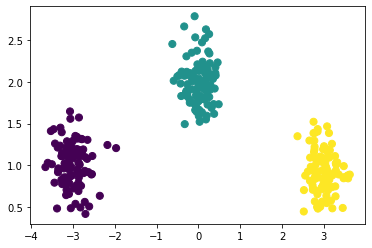

In [3]:
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plt.show()

In [4]:
class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0,..,(n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """
        Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        @param estimator : binary base classifier used
        @param n_classes : number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators[i] should be fit on class i vs rest
        @param X: array-like, shape = [n_samples,n_features], input data
        @param y: array-like, shape = [n_samples,] class labels
        @return returns self
        """
        for i in range(self.n_classes):
            self.estimators[i].fit(X, np.where(y==i, 1, 0))
        self.fitted = True  
        return self   

    def decision_function(self, X):
        """
        Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        @param X : array-like, shape = [n_samples, n_features] input data
        @return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        scores = np.zeros([len(X), self.n_classes])
        for i in range(self.n_classes):
            scores[:,i] = self.estimators[i].decision_function(X)
        return scores
    
    def predict(self, X):
        """
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples,n_features] input data
        @returns array-like, shape = [n_samples,] the predicted classes for each input
        """
        return np.argmax(self.decision_function(X) , axis=1)

13) Include the results of the test cell in your submission.

Coeffs 0
[[-1.05853334 -0.90294603]]
Coeffs 1
[[0.42121645 0.27171776]]
Coeffs 2
[[ 0.89164752 -0.82601734]]


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,  11,  89]])

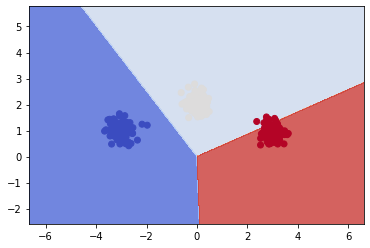

In [5]:
#Here we test the OneVsAllClassifier
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=200)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X,y)

for i in range(3) :
    print("Coeffs %d"%i)
    print(clf_onevsall.estimators[i].coef_) #Will fail if you haven't implemented fit yet

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

metrics.confusion_matrix(y, clf_onevsall.predict(X))

#### Multiclass SVM

In this question, we will implement stochastic subgradient descent for the linear multiclass SVM, as described in class and in this problem set. We will use the class-sensitive feature mapping approach with the “multivector construction”, as described in the multiclass lecture.

14) Complete the function `featureMap` in the skeleton code.

In [6]:
def featureMap(X, y, num_classes):
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], the class sensitive features for class y
    '''
    X,y = X.reshape(1,-1), np.array([y])
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
    X_features = np.zeros([num_samples, num_inFeatures*num_classes])
    for i in range(num_samples):
        for j in range(num_inFeatures):
            X_features[i, y[i]*num_inFeatures+j] = X[i,j]
    return X_features

15) Complete the function `sgd`.

In [7]:
def sgd(X, y, num_outFeatures, subgd, eta=0.1, T=10000):
    '''
    Runs subgradient descent, and outputs resulting parameter vector.
    @param X: array-like, shape = [n_samples,n_features], input training data 
    @param y: array-like, shape = [n_samples,], class labels
    @param num_outFeatures: number of class-sensitive features
    @param subgd: function taking x,y,w and giving subgradient of objective
    @param eta: learning rate for SGD
    @param T: maximum number of iterations
    @return: vector of weights
    '''
    w = np.zeros(num_outFeatures)
    for i in range(T):
        idx = np.random.choice(len(X))
        w -= eta*subgd(X[idx, :], y[idx], w)[0]     
    return w

16) Complete the methods `subgradient`, `decision_function` and `predict` from the class `MulticlassSVM`.

In [8]:
def zeroOne(y,a) :
    '''
    Computes the zero-one loss.
    @param y: output class
    @param a: predicted class
    @return 1 if different, 0 if same
    '''
    return int(y != a)

class MulticlassSVM(BaseEstimator, ClassifierMixin):
    '''
    Implements a Multiclass SVM estimator.
    '''
    def __init__(self, num_outFeatures, lam=1.0, num_classes=3, Delta=zeroOne, Psi=featureMap):       
        '''
        Creates a MulticlassSVM estimator.
        @param num_outFeatures: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        '''
        self.num_outFeatures = num_outFeatures
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X,y : Psi(X,y,num_classes)
        self.fitted = False
    
    def subgradient(self,x,y,w):
        '''
        Computes the subgradient at a given data point x,y
        @param x: sample input
        @param y: sample class
        @param w: parameter vector
        @return returns subgradient vector at given x,y,w
        '''
        margin = np.array([self.Delta(y,i) for i in range(self.num_classes)])
        score = [np.dot(w ,self.Psi(x,i)[0]) - np.dot(w, self.Psi(x,y)[0]) for i in range(self.num_classes)]
        y_hat = np.argmax(margin + score)
        return 2*self.lam*w + self.Psi(x,y_hat) - self.Psi(x,y)
        
    def fit(self,X,y,eta=0.1,T=10000):
        '''
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        '''
        self.coef_ = sgd(X,y,self.num_outFeatures,self.subgradient,eta,T)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''
        Returns the score on each input for each class. Assumes
        that fit has been called.
        @param X : array-like, shape = [n_samples, n_inFeatures]
        @return array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")
        scores = np.zeros([len(X), self.num_classes])
        for i in range(len(X)):
            scores[i] = np.array([np.dot(self.coef_,est.Psi(X[i],j)[0]) for j in range(self.num_classes)])
        return(scores)
            
    def predict(self, X):
        '''
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        @return array-like, shape = [n_samples,], class labels predicted for each data point
        '''
        return(np.argmax(self.decision_function(X), axis=1))

17) Following the multiclass SVM implementation, we have included another block of test code. Make sure to include the results from these tests in your assignment, along with your code.

w:
[-0.35659563 -0.04634579 -0.00120551  0.07900731  0.35780114 -0.03266152]


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

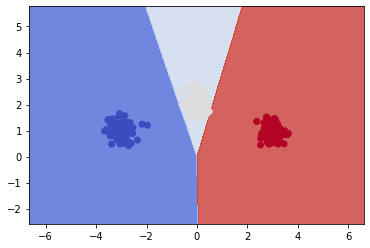

In [9]:
est = MulticlassSVM(6,lam=1)
est.fit(X,y,eta=0.001)
print("w:")
print(est.coef_)
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
metrics.confusion_matrix(y, est.predict(X))